In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
def construct_5diagonal_matrix(n_spt, alpha):
    
    """ n_spt - number of INSIDE (exclude boundaries) spatial steps of the problem
        alpha - problem factor
    """
    n = n_spt**2    # matrix size
    A = np.zeros((n,n))
    
    main_diag_factor = alpha + 4
    
    # near diagonals
    for i in range(n-1):
        A[i,i] = main_diag_factor
        A[i,i+1] = -1
        A[i+1,i] = -1
    
    A[n-1,n-1] = main_diag_factor
    
    # far diagonals
    for i in range(n-n_spt):
        A[i,n_spt+i] = -1
        A[n_spt+i,i] = -1

    return A

In [47]:
def construct_sol_vector(n_spt, alpha, dt, T, F):
    
    """ T - matrix from last state
    """
    n = n_spt**2
    
    T_flat = T[1:-1,1:-1].flatten()
    F_flat = F[1:-1,1:-1].flatten()
    
    b = alpha*T_flat + alpha*dt*F_flat
    
    # handled bondary cases
    for i in range(n_spt):
        for j in range(n_spt):
            
            current_b_index = i*n_spt + j
            
            if i==0 or j==0:
                b[current_b_index] += T[i,j]            
            if i==(n_spt-1):
                b[current_b_index] += T[-1,j]
            if j==(n_spt-1):
                b[current_b_index] += T[i,-1]
                    
    return b

In [18]:
def F(x,y,t):
    
    """
    """
    sigma = 0.00625
    x_power = -((x-1)**2)/(2*sigma**2)
    y_power = -((y-0.5)**2)/(2*sigma**2)
    t_power = -0.1*t
    
    return (-10**-4)*np.exp(x_power)*np.exp(y_power)*np.exp(t_power)

In [16]:
def plot_countours(arr,x,y,title=None,cmap="coolwarm"):
    
    """
    """
    xx, yy = np.meshgrid(x,y)

    fig, ax = plt.subplots(figsize=(16,9))
    ax.contourf(xx,yy,arr,cmap=cmap)


    ax.set_xlim([0,x[-1]])
    ax.set_ylim([y[-1],0])
    ax.xaxis.tick_top()
    
    fig.suptitle(title, fontsize=20)
    ax.set_xlabel("x", fontsize=16)
    ax.xaxis.set_label_position("top") 
    ax.set_ylabel("y", fontsize=16)
    
    im = ax.imshow(arr,cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="4%", pad=0.05)
    fig.colorbar(im, cax=cax)

    plt.show()
#     plt.savefig(f"{title}.png")

### define problem parameters

In [4]:
h = 0.05
x = np.arange(0,1.5+h,h)
y = np.arange(0,1.5+h,h)

dt = 0.1
t = np.arange(0,60+dt,dt)

kappa = 1.786*10**-3
alpha = h**2/(kappa*dt)

### construct T matrix - 3 dimensional array describing a spatial grid for every time step

In [8]:
spt_pts = len(x)    # number of spatial points
spt_pts_in = spt_pts - 2    # number of inner spatial points
t_pts = len(t)    # number of time points

T = np.zeros((spt_pts,spt_pts,t_pts))

# initial condition
T[:,:,0] = 10

# boundary conditions
T[:,0,:] = 100
T[:,-1,:] = 10
for k in range(t_pts):
    T[-1,:,k] = 100 - 60*y
    y1 = 100 - 112.5*y[y<=0.8]
    y2 = np.ones_like(y[y>0.8])*10
    T[0,:,k] = np.concatenate((y1,y2))

### construct F matrix - 3 dimensional array for describing F values at any given point and any given time

In [43]:
xx, yy, tt = np.meshgrid(x,y,t)
F_mat = F(xx,yy,tt)

In [49]:
%%time
A = construct_5diagonal_matrix(spt_pts_in,alpha)

for k in range(t_pts-1):
    b = construct_sol_vector(spt_pts_in, alpha, dt, T[:,:,k], F_mat[:,:,k])
    T_flat = np.linalg.solve(A,b)
    T[1:-1,1:-1,k+1] = T_flat.reshape(spt_pts_in,spt_pts_in)

Wall time: 12 s


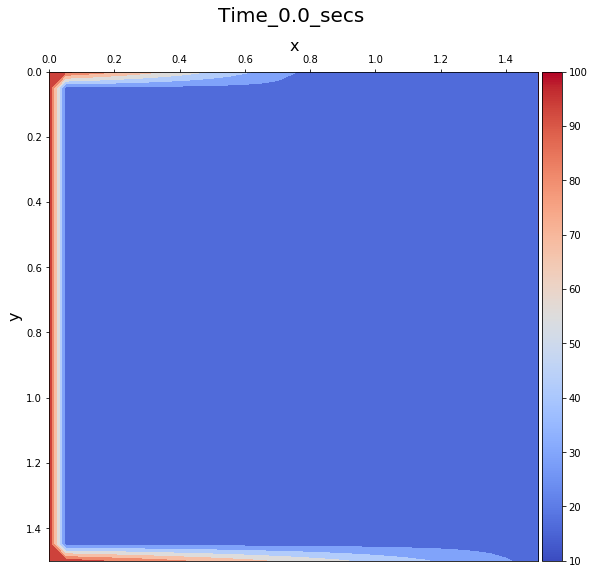

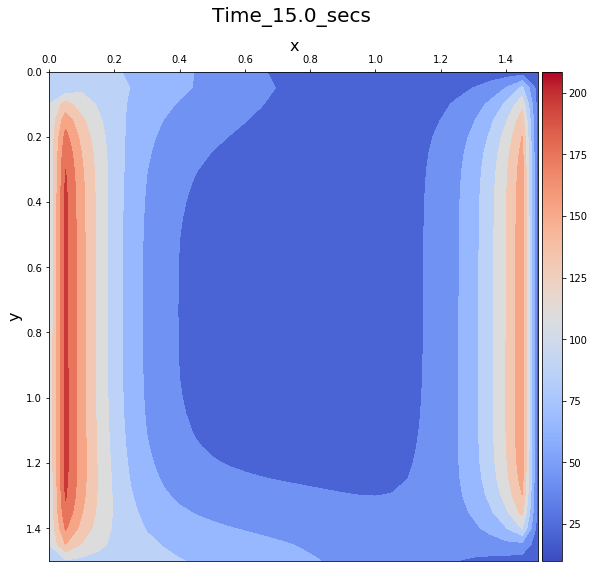

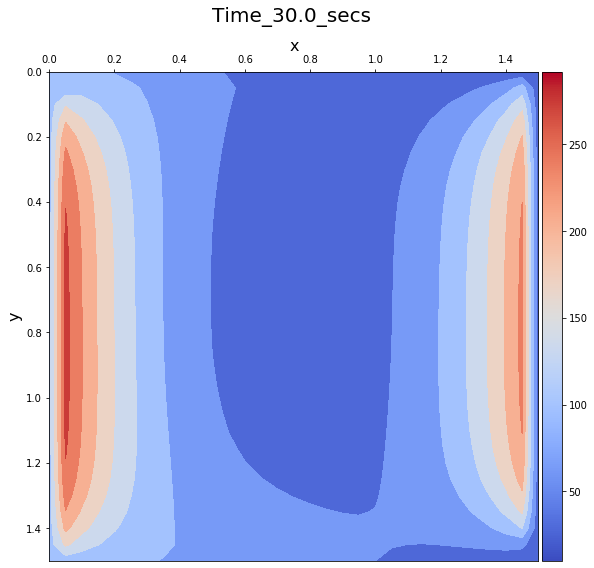

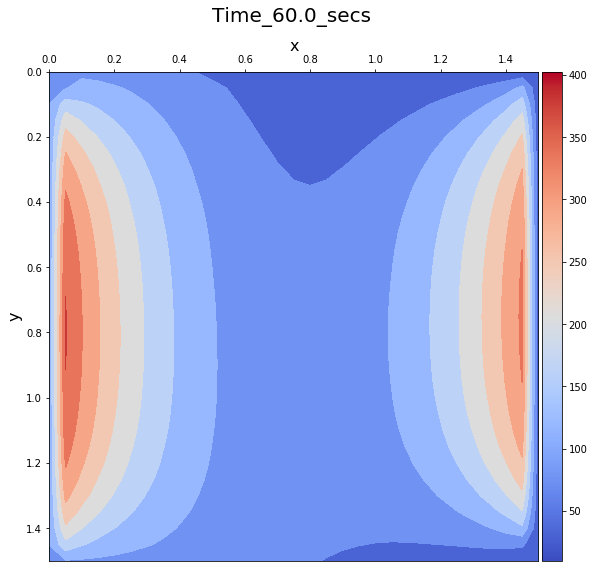

In [50]:
for ti in (np.array([0,15,30,60])/dt).astype(int):
    plot_countours(T[:,:,ti], x, y, title=f"Time_{ti*dt}_secs")